In [ ]:
!pip install Pillow # used to resize images

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import random
import shutil
import time
import glob
from tqdm.notebook import tqdm, trange

from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf

## Notebook one: Download and preprocess the COCO training images
Create a new notebook called "preprocessing.ipynb" for this part of the assignment.

In this section, you will download your starter CSV and the COCO training images. Preprocess the images from the starter CSV (by resizing them to 299x299 using Pillow), and create a zip file called "thumbnails.zip". Your zip should be around 500MB.

Finally, upload your "thumbnails.zip" to the Cloud, so you can easily download it in your second notebook.

### Tips

I recommend downloading the COCO images with curl, so you can resume your download if it is [interrupted](https://stackoverflow.com/questions/19728930/how-to-resume-interrupted-download-automatically-in-curl) or stalls.

In Colab (or on Linux / Mac):

```
$ curl -L -O your_url
```

You can download these images in Colab, but you may need to be mindful of disk usage. As a tip to save disk space, after unzipping them, you may delete any images from the zip not referenced in the starter code.

After you've downloaded them with curl, here's a command  you can use to unzip them:

```
$ unzip -q from_zip -d to_folder
```

Also note: there are so many images that opening the folder in the Colab will be slow. Instead of opening the folder with the UI, you can use these shell commands to explore it:

```
$ ls -lha
$ du -sh
```

### Download the starter CSV

In [ ]:
# Starter code to download small files
# Use this to download your starter CSV in notebook one and two.
# Also use it to download your thumbnails.zip in notebook two.
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
colab_root = "/content/"

In [ ]:
csv_path = os.path.join(colab_root, "starter2.csv")
download_if_missing("https://storage.googleapis.com/applied-dl/mini-vqa/starter2.csv",
                     csv_path)

1329146/1329146 [==============================] - 0s 0us/step


'/content/starter2.csv'

Tip. Here are a few shell commands you can use to quickly inspect the CSV and familiarize yourself with the format.

In [ ]:
!head $csv_path -n3 # take a look at a few rows

is this man a professional baseball player,yes,COCO_train2014_000000458752.jpg
is the dog waiting,yes,COCO_train2014_000000524291.jpg
is the sky blue,yes,COCO_train2014_000000393221.jpg


In [ ]:
!wc -l $csv_path

20000 /content/starter2.csv


### Download the COCO training images with curl

In [ ]:
# Your code here
# Download the training images with curl, and unzip them.
# If you're working in Colab, be mindful of disk usage.

!curl -L -O http://images.cocodataset.org/zips/train2014.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.5G  100 12.5G    0     0  42.1M      0  0:05:05  0:05:05 --:--:-- 46.9M


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy the zip file to drive google drive
!rsync -ah --progress train2014.zip /content/drive/MyDrive/Colab_Notebooks/ADL_HW3

sending incremental file list
train2014.zip
         13.51G 100%  100.95MB/s    0:02:07 (xfr#1, to-chk=0/1)


In [ ]:
!rsync -ah --progress /content/drive/MyDrive/Colab_Notebooks/ADL_HW3/train2014.zip ./

sending incremental file list


In [ ]:
!unzip -q train2014.zip -d ./

In [ ]:
!ls train2014/ | wc -l

82783


### Get to know your data.
Write code to display a few images, questions, and answers.

In [ ]:
# Your code here
# Familiarze yourself with the data.
# Add code to display a few images from the training set using matplotlib,
# and their corresponding questions and answers from the starter CSV.
# Don't trust that your data is perfect (any bugs are unintentional
# on our part, but there may well be some). The time you spend poking
# around with your data is always a good investment.

Total number of training pictures are: 82783


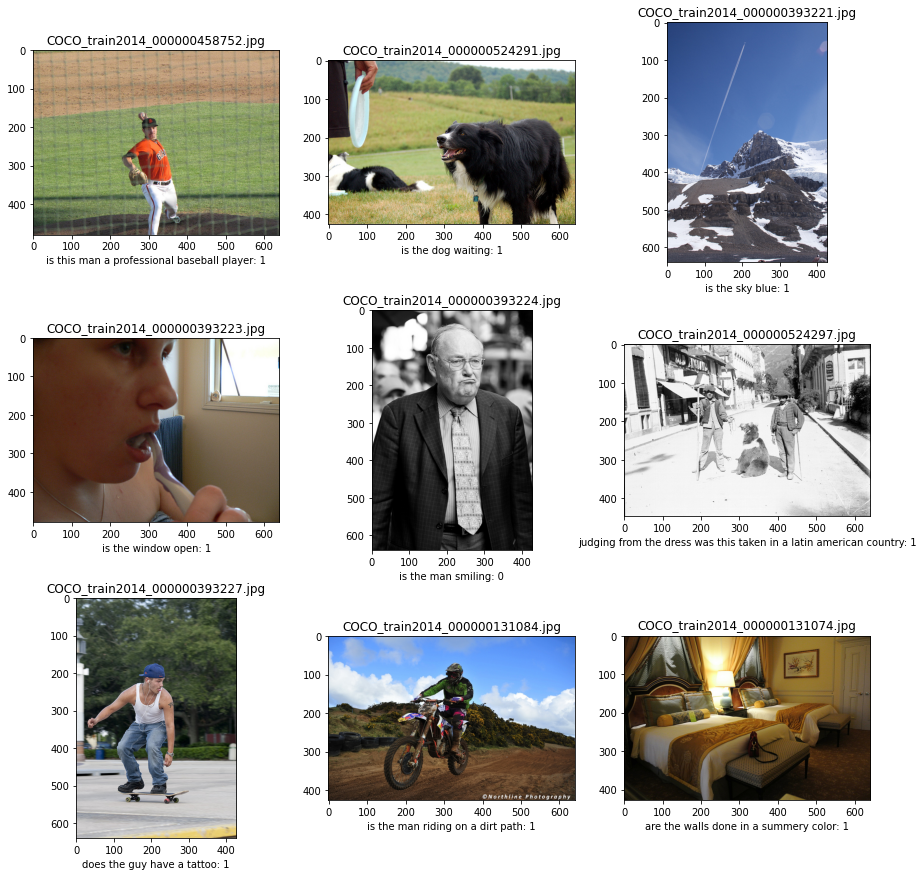

In [ ]:
data_dir = '/content/train2014'
starter_dir = '/content/starter2.csv'
df = pd.read_csv(starter_dir,
                  names=["question", "Answer", "picture"])
train_pics = glob.glob(f"{data_dir}/*.jpg")
print(f"Total number of training pictures are: {len(train_pics)}")

plt.figure(figsize=(15, 15))
for i in range(9):
    pic_file = df.iloc[i]['picture']
    ax = plt.subplot(3, 3, i + 1)
    for j in range(len(train_pics)):
        if pic_file in train_pics[j]:
            pic_ary = Image.open(train_pics[j])
            plt.imshow(pic_ary)
            plt.title(pic_file)
            plt.xlabel(f"{df.iloc[i]['question']}: {df.iloc[i]['Answer']}")


### As a sanity check, verify you can locate all the images
Write code to verfy you can find every image mentioned in your starter CSV in the unzipped COCO images you downloaded.

In [ ]:
# Your code here
# Write code to verify you can find every image mentioned in the starter
# CSV on disk. For example, you may want write a loop like this:
# import csv
# with open('starter2.csv') as myfile:
#    reader = csv.reader(myfile, delimiter=',')
#    for row in reader:
#       question, answer, image = row
#       image = image.strip()
#       assert os.path.exists(os.path.join(coco_images_folder, image))

In [ ]:
all_training_pic_dir = os.listdir(data_dir)

find_all = True
while find_all:
    for i in range(len(df)):
        image_file = df.iloc[i]['picture']
        if image_file not in all_training_pic_dir:
            find_all = False
            print(f"{image_file} not found")
    print("All pictures were found in the unzipped COCO images")
    find_all = False

All pictures were found in the unzipped COCO images


### Resize the images to 299x299
Next, resize the images referenced in your starter CSV to 299x299 using Pillow or other software. You can also do this using TF if you prefer.

### Tips
Here is code you can use to create a thumbnail of an image.

```
size = 299, 299
im = Image.open(path_to_image)
im.thumbnail(size)
out_file = os.path.join(your_directory, image_name)
im.save(out_file, "JPEG")
```

Note: do not change the image names when saving (your resized image names should exactly match the names in the starter code).

In [ ]:
# Your code here
# Resize all the images in the starter CSV to 299x299.
# Display a few and make sure the resize is working as expected.

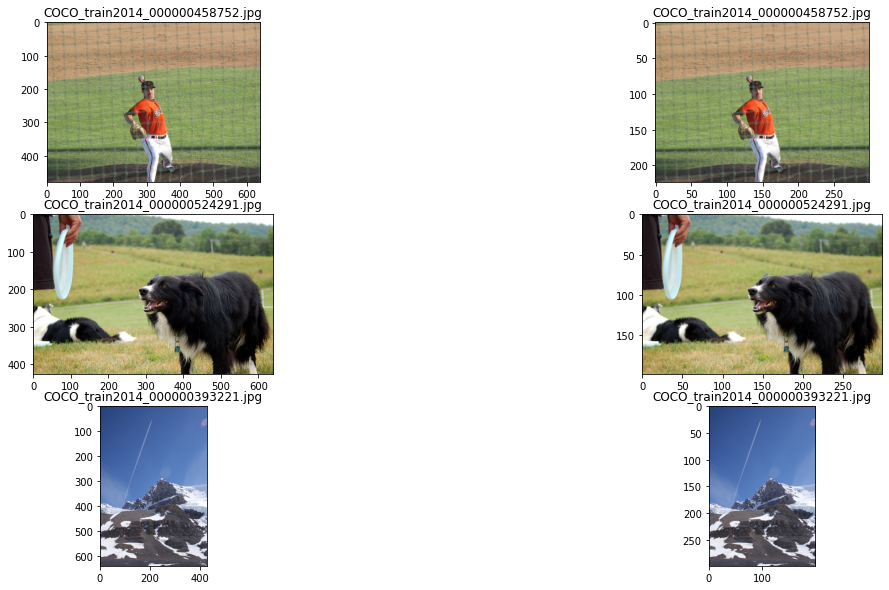

In [ ]:
size = 299, 299
plt.figure(figsize=(20, 10))
for i in range(3):
    pic_file = df.iloc[i]['picture']
    for j in range(len(train_pics)):
        if pic_file in train_pics[j]:
            ax = plt.subplot(3, 2, (2*i) + 1)
            pic_ary = Image.open(train_pics[j])
            plt.imshow(pic_ary)
            plt.title(pic_file)
            pic_ary.thumbnail(size)
            ax = plt.subplot(3, 2, (2*i) + 2)
            plt.imshow(pic_ary)
            plt.title(pic_file)



In [ ]:
subset_pics = df['picture']
subset_paths = [f"./train2014/{x}" for x in subset_pics]
print(len(subset_paths))

size = 299, 299
out_dir = "resized_Pic"
os.makedirs(out_dir, exist_ok=True)


for pic in tqdm(subset_paths):
    pic_name = pic.split("/")[-1]
    pic_ary = Image.open(pic)
    pic_ary.thumbnail(size) # thumbnail, not resize, but ok
    out_file = os.path.join(out_dir, pic_name)
    pic_ary.save(out_file)

20000


  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
resized_training_pic_dir = os.listdir(out_dir)

find_all = True
while find_all:
    for i in range(len(df)):
        image_file = df.iloc[i]['picture']
        if image_file not in resized_training_pic_dir:
            find_all = False
            print(f"{image_file} not found")
    print("All resized pictures were found in the starter")
    find_all = False

All resized pictures were found in the starter


### Create a zip of your resized images

### Tips
Here is code you can use to zip a directory, creating a new zip file "thumbnails.zip"

```
shutil.make_archive('thumbnails', 'zip', [directory_to_zip])
```

In [ ]:
# Your code here
# Create a thumbnails.zip
# Verify the size is around 500MB

In [ ]:
shutil.make_archive("thumbnails", "zip", out_dir)

'/content/thumbnails.zip'

In [ ]:
!ls -l --block-size=MB /content/thumbnails.zip

-rw-r--r-- 1 root root 268MB Nov 27 05:17 /content/thumbnails.zip


### Upload your thumbnails.zip to the Cloud

You want to host your thumbnails.zip file at a URL, for example: ```https://storage.googleapis.com/[your_bucket_name]/thumbnails.zip```, so you can easily download it in your second notebook.

You can use any Cloud provider. Google Cloud [storage buckets](https://cloud.google.com/storage/docs/creating-buckets) are fine for this. You can use the [free tier](https://cloud.google.com/free/).

After this is done, you're ready to start on notebook two.

In [ ]:
!cp thumbnails.zip /content/drive/MyDrive/Colab_Notebooks/ADL_HW3